## Lecture 12: Direct Image Reconstruction Methods

Goal: to describe Fourier and Radon transform based image reconstruction




In [1]:
## MP 574 Lecture 12: Direct Image Reconstruction
##
#%matplotlib inline
%matplotlib notebook
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, Image
import matplotlib.image as mpimg
from os.path import dirname, join as pjoin
from scipy import signal
import scipy.io as sio
import scipy.optimize as opt
import numpy.random as rnd
import time
import skimage.transform as transform
import skimage.data as data
import math 
from PIL import Image

font = {'weight' : 'normal',
        'size'   : 12}
np.set_printoptions(precision=2)

## Projection data

For tomographic imaging modalities (eg: CT), we can model our data  as projections along a certain angle $\theta$. Specifically, for parallel beam CT, we can model our data (after appropriate transformation) as follows:
$$ d(s,\theta) = \int \int x(r_1,r_2) \delta(r_1 \cos \theta + r_2 \sin \theta - s) d r_1  d r_2$$


Upon discretization we can  represent this projection relationship using matrix-vector notation, as:
$$ \mathbf{d} = \mathbf{P} \mathbf{x}$$
where $\mathbf{P}$ is a matrix that performs a set of projections on our discretized image, along a set of  angles. 

<IPython.core.display.Javascript object>


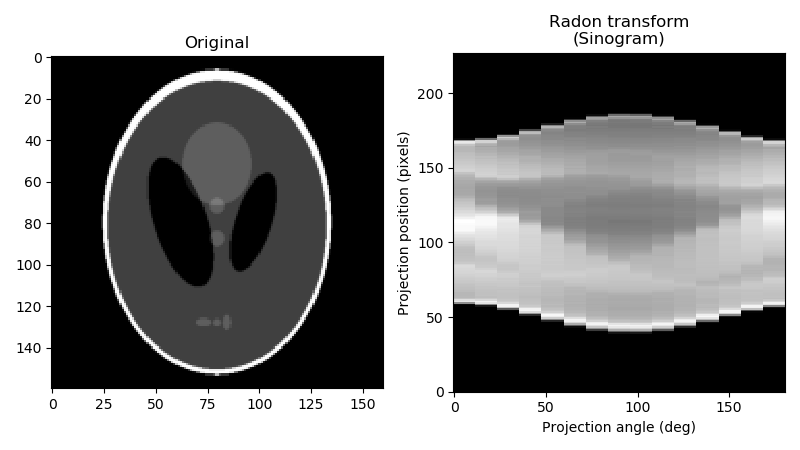

In [2]:
# Projection data (~Computed Tomography)

image = data.shepp_logan_phantom()
image = transform.rescale(image, scale=0.4, mode='reflect', multichannel=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

num_projections = 15;
theta = np.linspace(0., 180., num_projections, endpoint=False)
sinogram = transform.radon(image, theta=theta, circle=False)


dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')

fig.tight_layout()
plt.show()


BP rms reconstruction error: 32.3


<IPython.core.display.Javascript object>


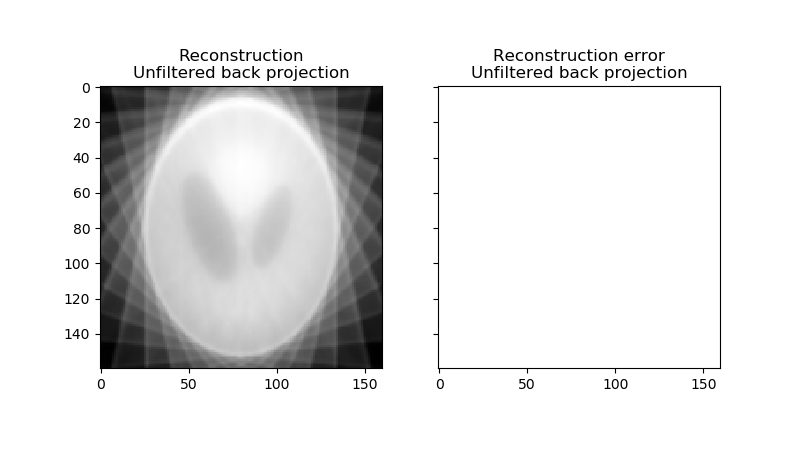

In [3]:
# Unfiltered backprojection

reconstruction_bp = transform.iradon(sinogram, theta=theta, circle=False, filter=None)
error = reconstruction_bp - image
print(f"BP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}")

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5),
                               sharex=True, sharey=True)
ax1.set_title("Reconstruction\nUnfiltered back projection")
ax1.imshow(reconstruction_bp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nUnfiltered back projection")
ax2.imshow(reconstruction_bp - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()

FBP rms reconstruction error: 0.188


<IPython.core.display.Javascript object>


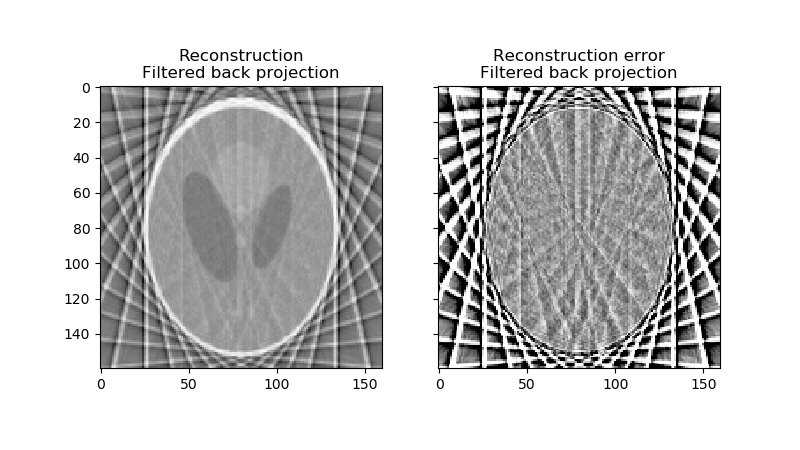

In [4]:
# Filtered backprojection

reconstruction_fbp = transform.iradon(sinogram, theta=theta, circle=False, filter='ramp')
error = reconstruction_fbp - image
print(f"FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}")

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5),
                               sharex=True, sharey=True)
ax1.set_title("Reconstruction\nFiltered back projection")
ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()

## Fourier data

In several imaging modalities (most notably MRI), there is a Fourier relationship between measurements and image, eg in the 2D case:
$$d(k_1, k_2) = \int \int x(r_1, r_2) e^{-i 2 \pi (k_1 r_1 + k_2 r_2)} d r_1 \, d r_2$$
where $r_1$ and $r_2$ represent the spatial coordinates in image space, $x(r_1, r_2)$ is the corresponding image, $k_1$ and $k_2$ represent the Fourier-space coordinates (termed k-space in MRI lingo), and  $d(k_1, k_2)$ represents the k-space measurements as a 2D array. 

Note that, upon discretization of our image and Fourier spaces, we can  represent this relationship using matrix-vector notation, as:
$$ \mathbf{d} = \mathbf{F} \mathbf{x}$$
where $\mathbf{F}$ is a matrix that performs a 2D DFT (or 3D DFT if performing 3D imaging) on the image that is represented (in vector form) by vector $\mathbf{x}$. 

<IPython.core.display.Javascript object>


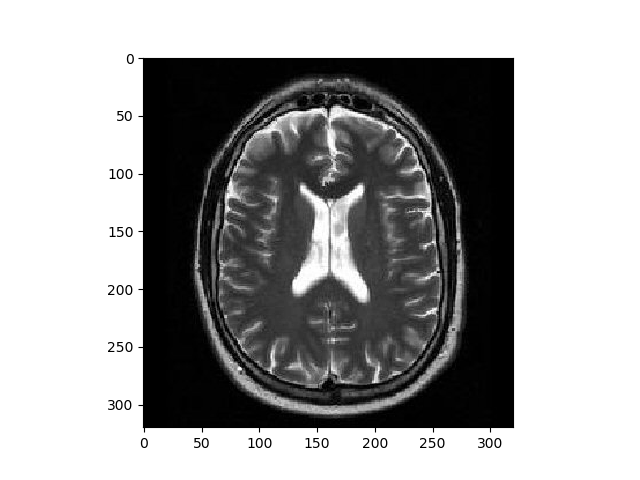

In [5]:
# Fourier data
# Load some image from file
data_dir = pjoin('.', 'data')
mat_fname = pjoin(data_dir, 'brain_orig.mat')
mat_contents = sio.loadmat(mat_fname)
mat_contents
f = mat_contents['im_mr']
sx = len(f)
sy = len(f[:])
fig2 = plt.figure()
imgplot = plt.imshow(abs(f),cmap='gray')

<IPython.core.display.Javascript object>


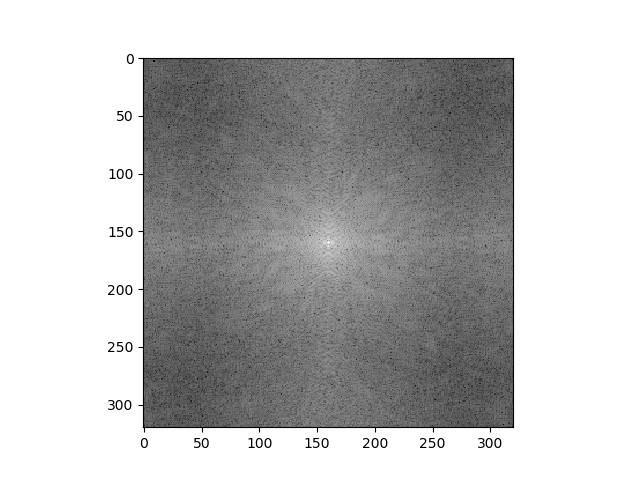

In [6]:
# Calculate and show the (Discrete) FT
fhat = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(f)))
fig2 = plt.figure()
imgplot = plt.imshow(np.log(abs(fhat)),cmap='gray')

# Noise and artifacts

Finally, we will add some noise or artifact to the Fourier data, and see what happens to the corresponding image. Note that in the next cell you can manipulate the type and level of artifact that is included in the Fourier data, and then visualize the effect on the reconstructed image.

In [7]:
# Now add some noise or artifact to the data
#fhat2 = fhat.copy(); fhat2[120,120] = fhat2[120,120] + 4E+4 # Uncomment this line for spike in Fourier-space
#fhat2 = 0*fhat; fhat2[30:70,30:70] = fhat[30:70,30:70] # Uncomment this to keep only the low frequencies

#The next few lines add some Gaussian noise (comment last line if unwanted)
sizex = len(fhat)
sizey = len(fhat[:])
std = 50
noise = np.random.normal(0,std,[sizex,sizey]) + np.random.normal(0,std,[sizex,sizey])*1j
fhat2 = fhat.copy(); fhat2 = fhat2 + noise

<IPython.core.display.Javascript object>


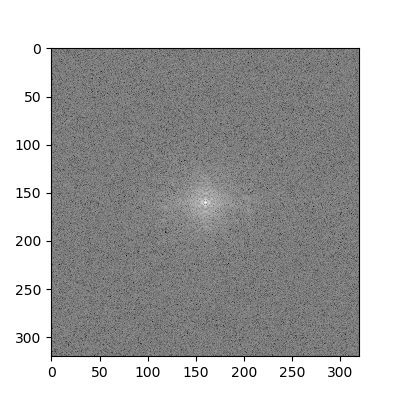

In [8]:
plt.figure(figsize=(4,4))
imgplot = plt.imshow(np.log(abs(fhat2 + 0.000000001)), cmap='gray')

<IPython.core.display.Javascript object>


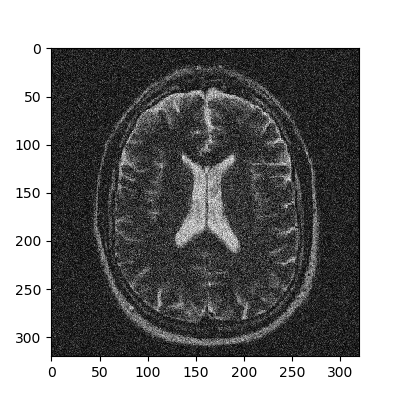

In [9]:
f2 = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(fhat2)))
plt.figure(figsize=(4,4))
imgplot = plt.imshow(abs(f2),cmap='gray')

## Motion artifacts

<IPython.core.display.Javascript object>


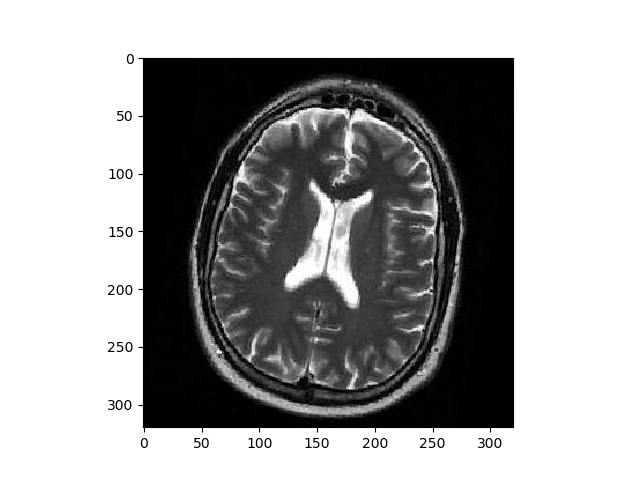

In [10]:
# Now add some motion with angle ROT_ANGLE and frequency ROT_FREQUENCY
ROT_ANGLE = 10
ROT_FREQUENCY = 0.05
f3hat = 0*fhat
fig = plt.figure()
ims = []
for k in range(0,sx):
#    myshift = np.int(np.round(8*np.sin(2*math.pi*0.02*k)))
#    f2 = np.roll(f,myshift,axis=0) # shift
    myrot = ROT_ANGLE*np.sin(2*math.pi*ROT_FREQUENCY*k)
    new_im = Image.fromarray(f)
    new_im2 = new_im.rotate(myrot,resample=Image.BICUBIC)
    f2 = np.array(new_im2)
    im = plt.imshow(abs(f2),cmap='gray',animated=True,vmin=0,vmax=1)
    
    ims.append([im])
    f2hat =  np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(f2)))
    f3hat[:,k] = f2hat[:,k]
ani = animation.ArtistAnimation(fig, ims, interval=100, blit=False,
                                repeat_delay=0)
plt.show()

<IPython.core.display.Javascript object>


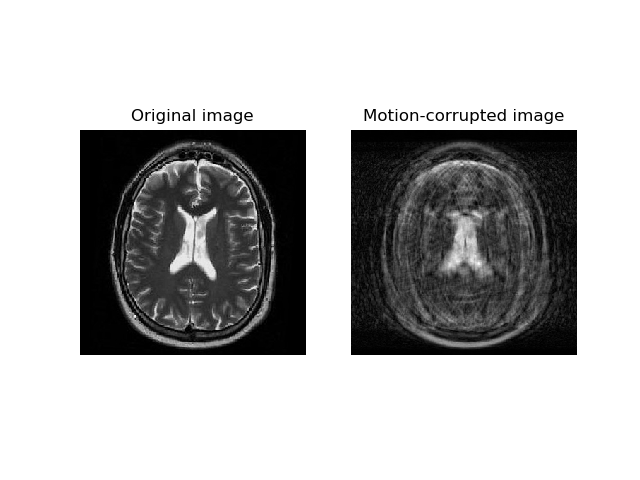

(-0.5, 319.5, 319.5, -0.5)

In [11]:
# Take our motion-corrupted data and reconstruct our image
f3 = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(f3hat)))

# Display both the original and motion-corrupted images
fig2 = plt.figure()
plt.subplot(1,2,1)
imgplot = plt.imshow(abs(f2),cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,2,2)
imgplot = plt.imshow(abs(f3),cmap='gray')
plt.title('Motion-corrupted image')
plt.axis('off')

